# Model building

In [43]:
#Credits to:
#https://towardsdatascience.com/choosing-a-scikit-learn-linear-regression-algorithm-dd96b48105f5

In [44]:
# Importing key libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, HuberRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import  mean_squared_error, r2_score

plt.style.use("bmh")

## Dataset preprocessing

In [45]:
dataset = pd.read_csv("Data/Processed/dataset.csv", index_col="Unnamed: 0", parse_dates=True)
tomorrow = pd.read_csv("Data/Processed/tomorrow.csv", index_col="Unnamed: 0", parse_dates=True)

In [46]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1064 entries, 2016-05-06 to 2020-10-12
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   xtb     1064 non-null   float64
 1   wig     1064 non-null   float64
 2   spx     1064 non-null   float64
 3   gld     1064 non-null   float64
 4   oil     1064 non-null   float64
 5   usd     1064 non-null   float64
 6   vix     1064 non-null   float64
dtypes: float64(7)
memory usage: 66.5 KB


In [47]:
# Chosing features and labels
labels = dataset["xtb"].values
features = dataset.drop("xtb", axis=1).values

In [48]:
scaler = StandardScaler()
scaler.fit(features)
features = scaler.transform(features)

In [49]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(features, 
                                                    labels, 
                                                    test_size=0.4, 
                                                    random_state=42)

## Model selection and metrics

In [50]:
lr = LinearRegression()
rge = Ridge()
hr = HuberRegressor()
dtr = DecisionTreeRegressor()
rfr = RandomForestRegressor()

In [84]:
results = pd.DataFrame(columns=["R2","RMSE"], index=["lr", "rge", "hr", "dtr", "rfr"])

for regressor, name in zip([lr, rge, hr, dtr, rfr], ["lr", "rge", "hr", "dtr", "rfr"]):
    regressor.fit(X_train, y_train)
    predictions = regressor.predict(X_test)
    results.loc[name]["R2"] = r2_score(y_test, predictions)
    results.loc[name]["RMSE"] = np.sqrt(mean_squared_error(y_test, predictions))

results = results.sort_values("R2", ascending=False)
results

,R2,RMSE
rfr,0.965555,0.712411
dtr,0.942541,0.920118
hr,0.610065,2.39696
rge,0.609518,2.39864
lr,0.608597,2.40147


In [87]:
print(results.to_markdown())

|     |       R2 |     RMSE |
|:----|---------:|---------:|
| rfr | 0.965555 | 0.712411 |
| dtr | 0.942541 | 0.920118 |
| hr  | 0.610065 | 2.39696  |
| rge | 0.609518 | 2.39864  |
| lr  | 0.608597 | 2.40147  |


In [79]:
# Best estimator parameters
rfr.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

## Searching for better parameters

## Cross Validation

In [77]:
cvscore = cross_val_score(rfr, X_train, y_train, cv=9)
print(f"R2: {cvscore.mean().round(4)}")

R2: 0.9593


## Feature importance

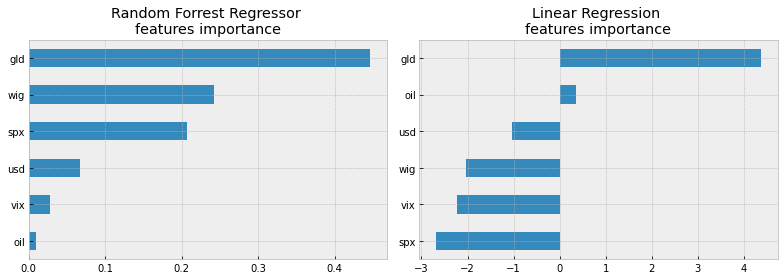

In [52]:
feature_imp_rfr = pd.Series(index=dataset.drop("xtb", axis=1).columns, 
                               data=rfr.feature_importances_ ,name="Coef").sort_values()

feature_imp_lr = pd.Series(index=dataset.drop("xtb", axis=1).columns, 
                               data=lr.coef_).sort_values()

# Features importance
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(11,4))

feature_imp_rfr.plot(kind="barh", ax=ax[0], subplots=True)
ax[0].set(title="Random Forrest Regressor \nfeatures importance")
feature_imp_lr.plot(kind="barh", ax=ax[1], subplots=True)
ax[1].set(title="Linear Regression \nfeatures importance")

plt.tight_layout()
plt.show()

## Model with the highest R2 score results

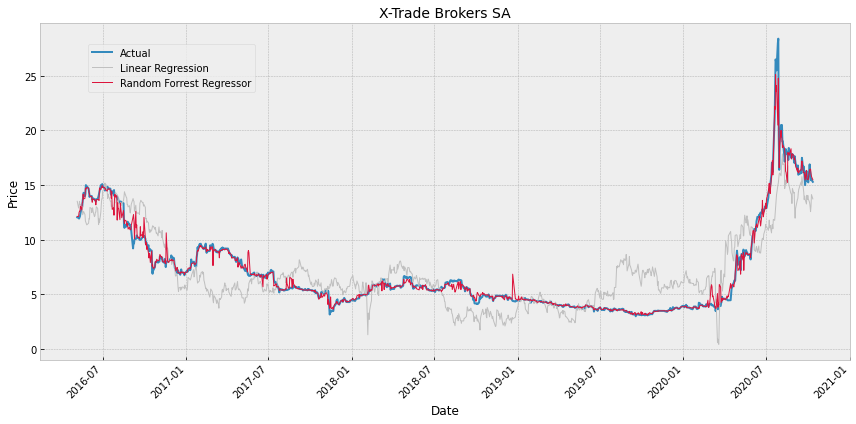

In [80]:
# Plotting model predictions

fig, ax = plt.subplots(figsize=(12,6))
fig.autofmt_xdate(rotation=45)

ax.set(xlabel="Date", ylabel="Price", yscale="linear")
ax.set_title(label="X-Trade Brokers SA", fontsize=14)

ax.plot(dataset.index, dataset.xtb, linewidth=2)
ax.plot(dataset.index, pd.Series(lr.predict(features)), linewidth=1, c="silver")
ax.plot(dataset.index, pd.Series(rfr.predict(features)), linewidth=1, c="crimson")

fig.legend(["Actual", "Linear Regression", "Random Forrest Regressor"], loc="upper left", bbox_to_anchor=(0.1, 0.9))

plt.tight_layout()
plt.show()

## Next day price prediction

In [54]:
scaler.fit(tommorow)
tomorrow = scaler.transform(tomorrow)

next_price = rfr.predict(tommorow.values.reshape(1,-1))
print("RFR Prediction for tommorow:","\t", next_price)

RFR Prediction for tommorow: 	 [14.622796]
